In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize 


In [3]:
# -- RISK PARITY WITH ASSET ALLOCATION -- 

In [4]:
tickers = ["^GSPC","GLD","BLGBX"]
data = yf.download(tickers,interval='1mo',period='15y',auto_adjust=True)

[*********************100%***********************]  3 of 3 completed


In [5]:
prices = data['Close']
returns = prices.pct_change().dropna()

In [6]:
cov_matrix = returns.cov() * 12
num_assets = len(tickers)

In [7]:
def portfolio_vol(weights,cov_matrix):

    std_dev=np.sqrt(np.dot(weights.T,np.dot(cov_matrix,weights)))

    return std_dev


In [8]:
def  rc_calculator(weights, cov_matrix):

    p_vol = portfolio_vol(weights, cov_matrix)

    # Marginal Risk Contribution (MRC)
    cov_dot_w = np.dot(cov_matrix, weights) 
    mrc = cov_dot_w / p_vol

    rc = weights * mrc

    return rc
    

In [9]:
def sum_calculator(weights,cov_matrix):

    rc = rc_calculator(weights, cov_matrix)
    target_rc = np.mean(rc)

    error = np.sum((rc-target_rc)**2)

    return error

In [10]:
def weight_calculator(cov_matrix):

    n = cov_matrix.shape[0]
    initial_guess = np.repeat(1/n, n)

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0})

    bounds = tuple((0.0, 1.0) for _ in range(n))

    result = minimize(fun=sum_calculator,
                      x0=initial_guess,
                      args=(cov_matrix,),
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints,
                      options={'ftol': 1e-12, 'maxiter': 1000})
    
    return result.x

In [11]:
optimal_weights = weight_calculator(cov_matrix)

print("The Risk Parity results are:")

final_rc = rc_calculator(optimal_weights, cov_matrix)
total_risk = portfolio_vol(optimal_weights, cov_matrix)

results_df = pd.DataFrame({
    'Asset': tickers,
    'Weight': optimal_weights,
    'Risk Contribution': final_rc,
    '% of Total Risk': final_rc / total_risk
})

pd.options.display.float_format = '{:.4f}'.format
print(results_df)
print("-" * 40)
print(f"Total Portfolio Volatility: {total_risk:.4f}")

The Risk Parity results are:
   Asset  Weight  Risk Contribution  % of Total Risk
0  ^GSPC  0.3183             0.0318           0.3333
1    GLD  0.2876             0.0318           0.3333
2  BLGBX  0.3941             0.0318           0.3333
----------------------------------------
Total Portfolio Volatility: 0.0955


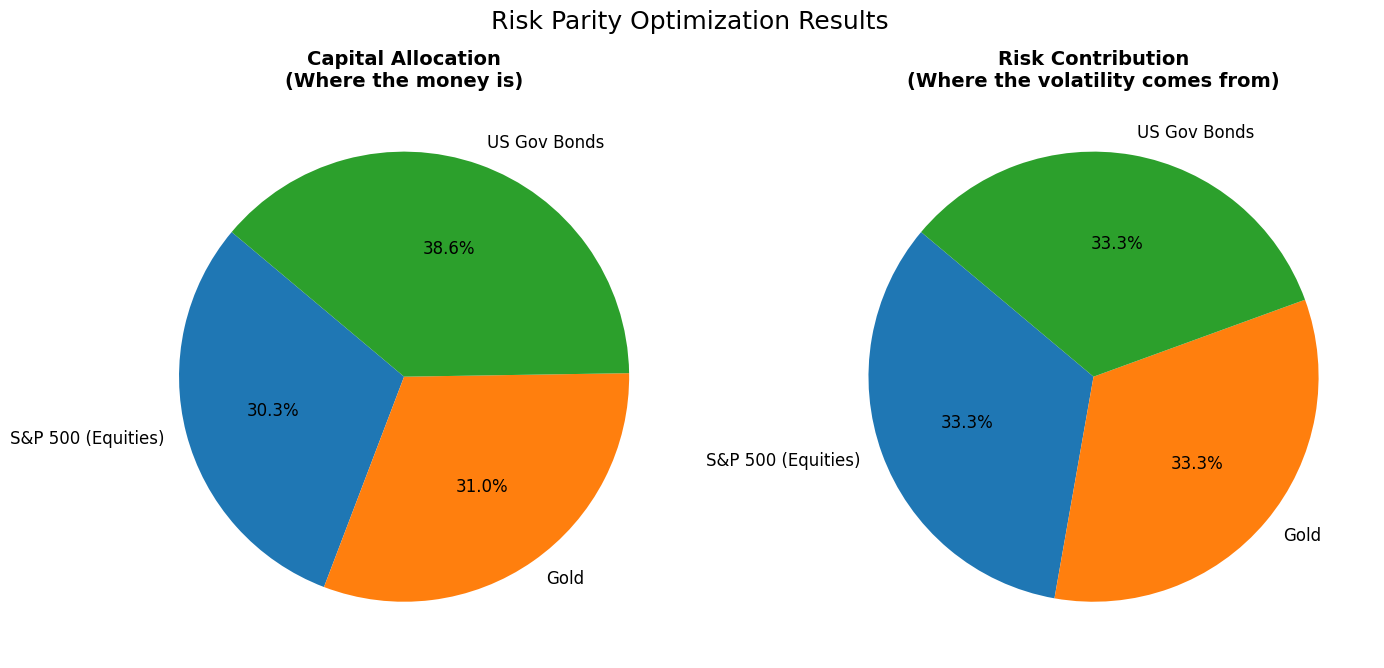

In [12]:
assets = ['S&P 500 (Equities)', 'Gold', 'US Gov Bonds']
weights = [0.3032, 0.3104, 0.3864]  
risk_contribution = [0.3333, 0.3333, 0.3333] 

fig, ax = plt.subplots(1, 2, figsize=(14, 7))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Blue, Orange, Green

ax[0].pie(weights, 
          labels=assets, 
          autopct='%1.1f%%', 
          startangle=140, 
          colors=colors,
          textprops={'fontsize': 12})
ax[0].set_title('Capital Allocation\n(Where the money is)', fontsize=14, fontweight='bold')

ax[1].pie(risk_contribution, 
          labels=assets, 
          autopct='%1.1f%%', 
          startangle=140, 
          colors=colors,
          textprops={'fontsize': 12})
ax[1].set_title('Risk Contribution\n(Where the volatility comes from)', fontsize=14, fontweight='bold')

plt.suptitle('Risk Parity Optimization Results', fontsize=18)
plt.tight_layout()
plt.show()